In [17]:
import pandas as pd
import numpy as np

temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break

temp = None
texts = None
words_list = None


df1 = pd.read_csv('Data/Samples_1.csv')
df2 = pd.read_csv('Data/Samples_2.csv')
df3 = pd.read_csv('Data/Samples_3.csv')
df = pd.concat([df1,df2,df3])
df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
temp = df.loc[df['words']=='[UNRECOGNIZED]']
df1 = df.loc[df['words']!='[UNRECOGNIZED]']
df2 = temp.sample(frac=0.005)
df = pd.concat([df1,df2])
print(len(df))

df1 = None
df2 = None
df3 = None

df.head()

122636


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_2991,sample_2992,sample_2993,sample_2994,sample_2995,sample_2996,sample_2997,sample_2998,sample_2999,words
0,129,206,227,208,275,402,474,559,658,880,...,-6458,-4407,-2736,-1968,0,0,0,0,0,learn
1,-4786,-3695,-694,2025,3114,2906,1890,1563,2868,4372,...,6378,-4740,-14274,-14041,0,0,0,0,0,to
3,718,165,-1624,-1544,1007,620,1096,-1256,-1975,60,...,345,1353,1125,-5120,-5043,-3150,-4747,-5659,-5833,omens
4,320,-109,590,895,389,334,871,948,1581,1838,...,-20211,-20799,-21697,-18167,0,0,0,0,0,and
6,508,-265,-1375,-2541,-3028,-2754,-2325,-2041,-2351,-2699,...,41,-133,-379,-513,0,0,0,0,0,them


In [18]:
from sklearn.preprocessing import LabelBinarizer
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint



X = df.drop('words',axis=1)
y_raw = df['words']

lb = LabelBinarizer()
y = lb.fit_transform(y_raw)
print(y.shape)


X_train,X_val,y_train,y_val = train_test_split(X,y)
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_val_scale = ss.transform(X_val)


y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

if len(d_class_weights)<y.shape[1]:
    init_len = len(d_class_weights)
    diff = y.shape[1]-init_len
    for i in range(diff):
        ind = init_len + i
        d_class_weights[ind] = 0

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

(122636, 1009)


D:\Alex\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[   0    1    2 ... 1006 1007 1008], y=[873 269 846 ... 339 842 366] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

Compiled
91977/91977 [==============================] - 53s 573us/step
----------
Training Loss: 7.07 
Training Accuracy: 0.0906
30659/30659 [==============================] - 17s 553us/step
----------
Validation Loss: 7.27 
Validation Accuracy: 0.000359


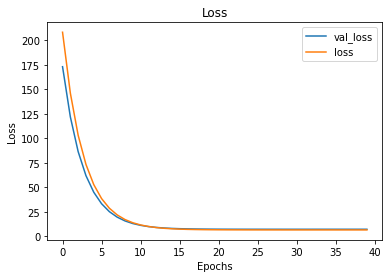

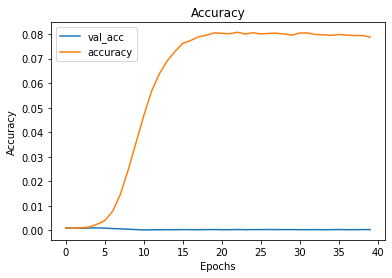

In [19]:
model = models.Sequential()
model.add(layers.Dropout(0.1,input_shape=(3000,)))
model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
model.add(layers.Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
print('Compiled')



results=model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)


results_train = model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

In [20]:
model.evaluate(X_val_scale,y_val)

30659/30659 [==============================] - 17s 551us/step


[7.273317175347914, 0.0003587853570934385]